In [0]:
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# plt.xkcd()
import seaborn as sns
import pandas as pd
%matplotlib inline
plt.rcParams['axes.grid']= True
plt.rcParams['grid.linestyle'] = '--'

## Decisions
- Diminishing return $P(n) = 1 - (1-p)^n$
- Threshhold $P(b) = \delta(b > b_{0}) $

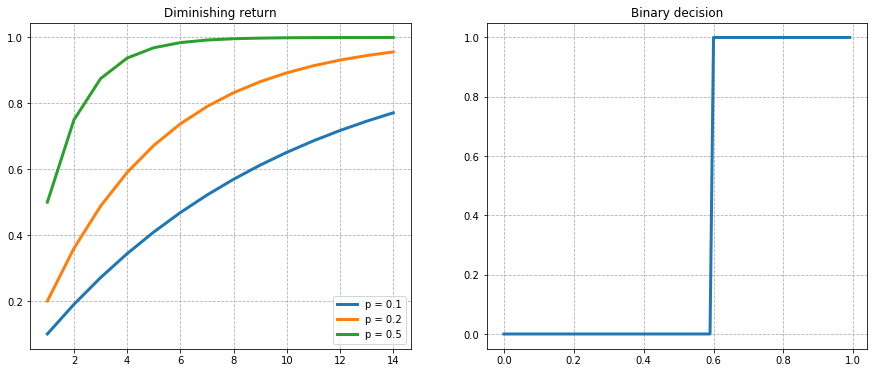

In [0]:
n_range = np.arange(1,15)
p_range = [0.1,0.2,0.5]
result = [(n,p,1 - np.power(1 - p, n)) for n in n_range for p in p_range]
df = pd.DataFrame(result,columns = ['n','p','v'])

figsize(15,6)
plt.subplot(1,2,1)
for p in p_range:
    plt.plot(df.loc[df.p == p,'n'],df.loc[df.p==p,'v'],label = 'p = '+str(p),linewidth = 3)
plt.legend()
plt.title("Diminishing return")

plt.subplot(1,2,2)
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01) >= 0.6,linewidth = 3)
plt.title("Binary decision")
plt.show()

## Model
1. Independent Cascade Model
2. Linear Threshold Model

## Independent Cascade Model

A special type of SIR model, a node stay infected only for one step

In [0]:
def influence_prop(G,theta = 2.0/5,initial_active_index = [0,1,2],max_iter = 10000,verbose = True):


    '''
        Influence propagation
        Parameters:
        --------
            G: networkx graph
            theta: threshold
            initial_active_index: position of initially active nodes
            max_iter: maximum iterations

        Returns:
        --------
            initial active nodes - boolean array
            final active nodes - boolean array
    '''

    # adjacency matrix
    A = np.array(nx.adjacency_matrix(G).todense())
    n = A.shape[0]
    deg = A.sum(axis = 0)

    init_active = np.zeros((n,),dtype = bool)
    init_active[initial_active_index] = 1

    cur_active = init_active.copy()

    for i in tqdm(range(1, max_iter)):
        inactive_ids = np.where(cur_active == 0)[0]

        # propagation
        # for each inactive node, thresholding -> percent of active neighbors / node degree
        # 1. construct a sub-adjacency matrix, with columns been inactive nodes, rows been active nodes
        # 2. calculate how many active neighbors each inactive node has
        # 3. devided by node degree
        # 4. thresholding
        # results in an boolean array with lenth = number of inactive nodes

        idx = (A[np.ix_(cur_active ==1,cur_active ==0)].sum(axis = 0) / deg[cur_active==0] ) > theta

        # if there are any nodes been infected - propagate
        # else - stop

        if np.any(idx):
            cur_active[inactive_ids[idx]] = 1
        else:
            break
        
        # print results
        if verbose:
            infected = np.where(cur_active ==1)[0]
            print('Round {} infected {}'.format(i-1,infected))

    return init_active,cur_active

### Simulate

  0%|          | 0/9999 [00:00<?, ?it/s]


Round 0 infected [ 1 11 25 42 45 50 58 64 66 75 90]
Round 1 infected [ 1 11 25 34 42 45 50 58 64 66 75 90]


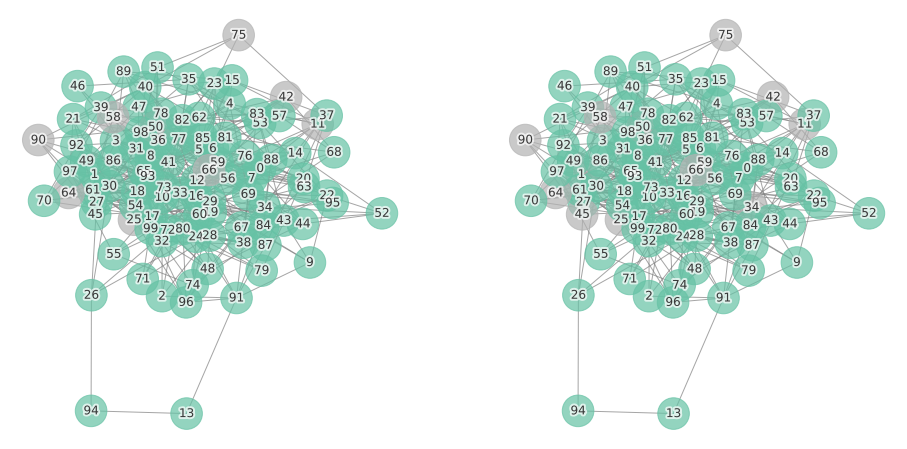

In [0]:
# G = nx.erdos_renyi_graph(100, 0.15)
# i_act,c_act = influence_prop(G,0.2,[0,1,2,4,6,88,5,10],5)

# G = nx.erdos_renyi_graph(10, 0.4)
# i_act,c_act = influence_prop(G,0.4,[0,1,2],5)

G = nx.erdos_renyi_graph(100, 0.08)
i_act,c_act = influence_prop(G,0.3,np.random.choice(np.arange(100),size = 10))

pos = nx.spring_layout(G)
figsize(16,8)
plt.xkcd()
plt.subplot(1,2,1)
nx.draw(G,with_labels = True,node_color = i_act,cmap = plt.get_cmap('Set2'),node_size = 1000,pos = pos,alpha = 0.7,edge_color = 'gray')
plt.subplot(1,2,2)
nx.draw(G,with_labels = True,node_color = c_act,cmap = plt.get_cmap('Set2'),node_size = 1000,pos = pos,alpha = 0.7,edge_color = 'gray')
plt.show()

In [0]:
def diminishing_return(G,p = 0.3,thresh = 0.5,initial_active_index = [0,1,2],max_iter = 10000,verbose = True):


    '''
        Influence propagation
        Parameters:
        --------
            G: networkx graph
            p: probability of a node been infected by an activated neighbor
            thresh: threshold for a node to be activated
            initial_active_index: initial acticated node index
            max_iter: maximum number of iteerations
            verbose: if print out details
        Returns:
        --------
            initial active nodes - boolean array
            final active nodes - boolean array
    '''

    # adjacency matrix
    A = np.array(nx.adjacency_matrix(G).todense())
    n = A.shape[0]
    deg = A.sum(axis = 0)

    init_active = np.zeros((n,),dtype = bool)
    init_active[initial_active_index] = 1

    cur_active = init_active.copy()

    for i in tqdm(range(1, max_iter)):
        inactive_ids = np.where(cur_active == 0)[0]

        # propagation
        # for each inactive node, thresholding -> percent of active neighbors / node degree
        # 1. construct a sub-adjacency matrix, with columns been inactive nodes, rows been active nodes
        # 2. calculate how many active neighbors each inactive node has
        # 3. calculate diminishing returns
        # 4. thresholding
        # results in an boolean array with lenth = number of inactive nodes

        ns = A[np.ix_(cur_active ==1,cur_active ==0)].sum(axis = 0)
        idx = 1 - np.power(1 - p, ns) > thresh


        # if there are any nodes been infected - propagate
        # else - stop

        if np.any(idx):
            cur_active[inactive_ids[idx]] = 1
        else:
            break
        
        # print results
        if verbose:
            infected = np.where(cur_active ==1)[0]
            print('Round {} infected {}'.format(i-1,infected))

    return init_active,cur_active

100%|██████████| 2/2 [00:00<00:00, 446.20it/s]


Round 0 infected [ 2  7  8  9 10 13 15 16 18]
Round 1 infected [ 2  3  5  7  8  9 10 11 13 15 16 18]


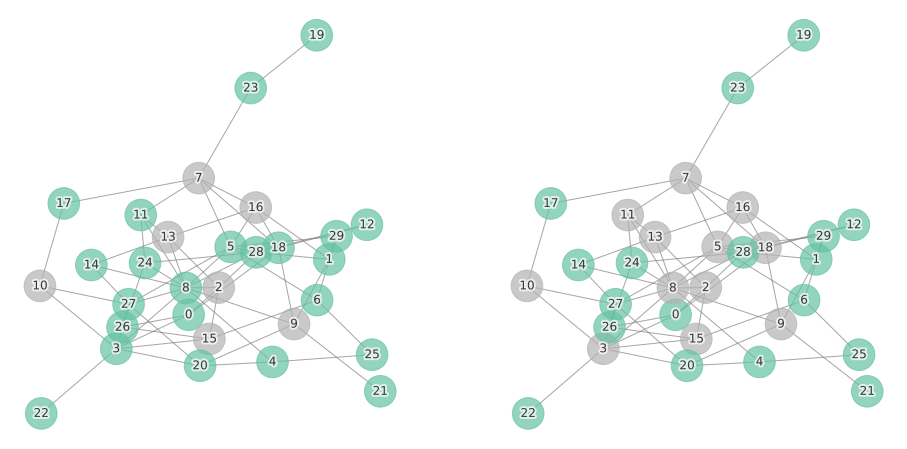

In [0]:
G = nx.erdos_renyi_graph(30, 0.15)
i_act,c_act = diminishing_return(G,0.3,0.55,np.random.choice(np.arange(20),size = 8),3)

pos = nx.spring_layout(G)
figsize(16,8)
plt.xkcd()
plt.subplot(1,2,1)
nx.draw(G,with_labels = True,node_color = i_act,cmap = plt.get_cmap('Set2'),node_size = 1000,pos = pos,alpha = 0.7,edge_color = 'gray')
plt.subplot(1,2,2)
nx.draw(G,with_labels = True,node_color = c_act,cmap = plt.get_cmap('Set2'),node_size = 1000,pos = pos,alpha = 0.7,edge_color = 'gray')
plt.show()

### Network coordination game
*Let u,v be player, A and B are possible strategies*
*Payoffs*
- if u and v both adopt behavior A, each get payoff a > 0
- if u and v both adopt behavior B, each get payoff b > 0
- if u and v adopt opposite behavior, each get payoff 0

Rewarded for same decision

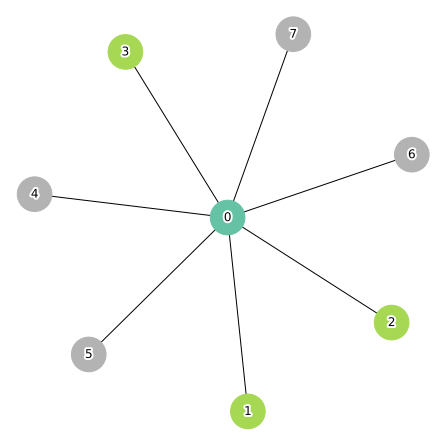

In [0]:
G = nx.star_graph(7)
figsize(6,6)
colors = [1,2,2,2,3,3,3,3]
nx.draw(G,with_labels = True,node_color = colors,node_size = 1200,cmap = plt.get_cmap("Set2"))

*Intuition: Payoff is enough to swith from technology A to B*

Node V to make a decision A or B, portion of type A neighbors to accept A:        
$a \cdot p \cdot d > b \cdot (1-p) \cdot d$   
$p>= b / (a+b)$

Threshold:
$q = b/(a+b)$

Accept new behavior A when $p >=q$


If Technology A is much better than B ($a>>b$), threshold will getting smaller

### Cascade Propagation 
- sequence of changes of behavior. 'Chain reaction'

In [0]:
def make_sample_graph():

    edges = [(1,2),(1,3),(2,3),(2,6),(6,4),(4,5),
            (5,8),(8,10),(10,9),(9,6),(4,7),(5,7),
            (8,7),(10,7),(9,7),(9,11),(10,12),(11,12),
            (11,15),(12,15),(12,13),(12,16),(15,16),(13,16),
            (13,14),(13,17),(16,17),(14,17),(8,14)
            ]

    T = nx.from_edgelist(edges)
    T = nx.relabel_nodes(T,{n:n -1for n in T.nodes()},copy=True)

    G = nx.Graph()
    G.add_nodes_from(sorted(T.nodes()))
    G.add_edges_from(T.edges())
    return G

In [0]:
def cascade_propagation(G,a,b,init_active = [6,7],max_iter = 100000):
    '''
        Implement cascade propagation

        Network coordination game
        Let u,v be player, A and B are possible strategies
        Payoffs:

        - if u and v both adopt behavior A, each get payoff a > 0
        - if u and v both adopt behavior B, each get payoff b > 0
        - if u and v adopt opposite behavior, each get payoff 0

        Parameters:
        --------
            G: networkx graph - graph to propagate
            a: reward for propagation - number
            b: reward for stay current state - number
            init_active: initial active nodes - list
            max_iter: number of iterations - integeer

        Returns:
        --------
            initial state vector, ndarray
            final state vector, ndarray

    '''

    # threshold
    q = b / (a + b)

    n_nodes = len(G.nodes())
    A = np.array(nx.adj_matrix(G).todense())
    deg = A.sum(axis = 0)

    cur_active = np.zeros(n_nodes,dtype = int)
    cur_active[init_active] = 1
    init_active = cur_active.copy()

    for i in range(max_iter):
        print("Iteration {}".format(i))
        inactive_ids = np.where(cur_active ==0)[0]
        idx = A[np.ix_(cur_active ==1, cur_active ==0)].sum(axis = 0) / deg[cur_active ==0] > q
        if np.any(idx):
            cur_active[inactive_ids[idx]] = 1
            print('Infect nodes: {}'.format(inactive_ids[idx]))
        else: 
            print("Finished propagation")
            break

    return (init_active,cur_active)

In [0]:
def show_propagation(G,init_active,final_active):
    figsize(15,6)
    pos = nx.spring_layout(G)
    plt.subplot(1,2,1)
    nx.draw(G,with_labels = True,node_size = 1200,node_color = init_active,cmap = plt.get_cmap('Set2'),pos = pos)
    plt.title("Initial states")
    plt.subplot(1,2,2)
    nx.draw(G,with_labels = True,node_size = 1200,node_color = final_active,cmap = plt.get_cmap('Set2'),pos = pos)
    plt.title("Final states")
    plt.show()

Iteration 0
Infect nodes: [4 9]
Iteration 1
Infect nodes: [3 8]
Iteration 2
Infect nodes: [5]
Iteration 3
Finished propagation


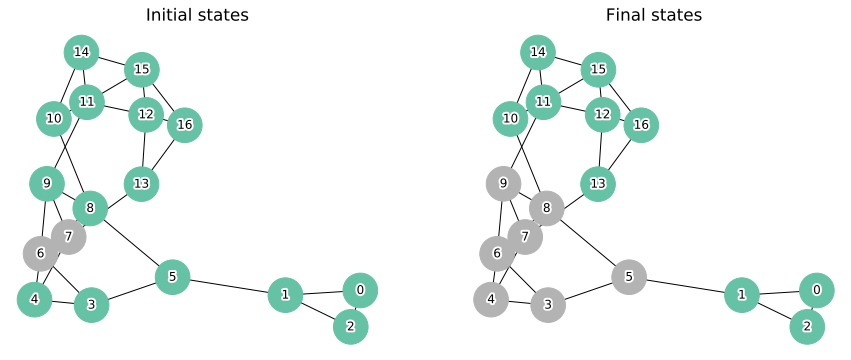

In [0]:
G = make_sample_graph()
init_active, final_active = cascade_propagation(G,
                                                a = 3,
                                                b = 2,
                                                init_active = [6,7],
                                                max_iter = 100000)

show_propagation(G,init_active,final_active)

Iteration 0
Infect nodes: [ 7 11 12 17 19 21]
Iteration 1
Infect nodes: [3]
Iteration 2
Infect nodes: [13]
Iteration 3
Infect nodes: [2]
Iteration 4
Infect nodes: [9]
Iteration 5
Finished propagation


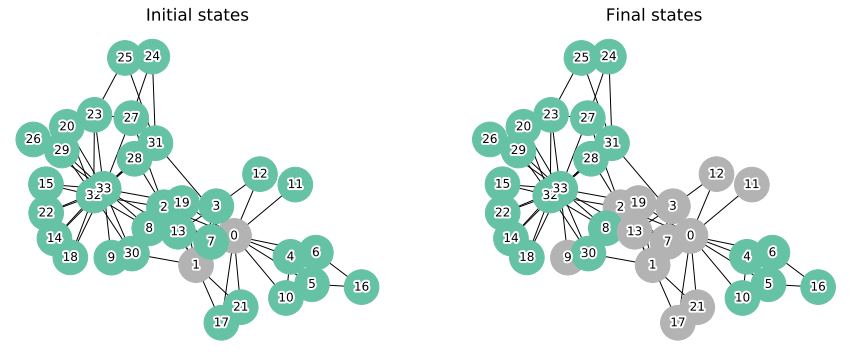

In [0]:
G = nx.karate_club_graph()
init_active, final_active = cascade_propagation(G,
                                                a = 3,
                                                b = 2,
                                                init_active = [0,1],
                                                max_iter = 100000)

show_propagation(G,init_active,final_active)

Iteration 0
Infect nodes: [ 9 14 15 18 20 22 26 29 30]
Iteration 1
Infect nodes: [ 8 23]
Iteration 2
Infect nodes: [27]
Iteration 3
Finished propagation


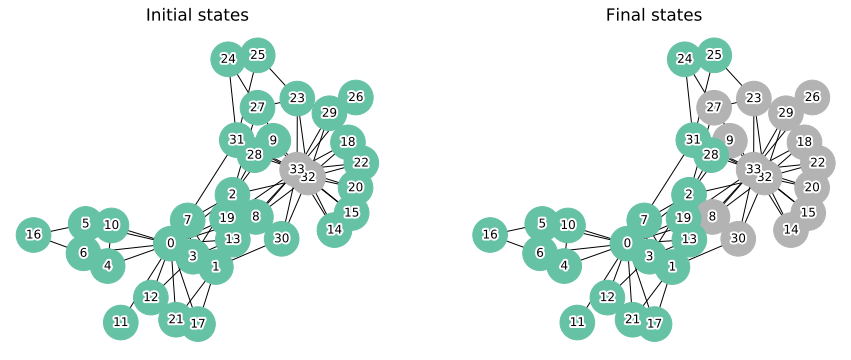

In [0]:
G = nx.karate_club_graph()
init_active, final_active = cascade_propagation(G,
                                                a = 3,
                                                b = 2,
                                                init_active = [32,33],
                                                max_iter = 100000)

show_propagation(G,init_active,final_active)

*Cluster density:*
- For each node, find fraction of neighbors inside the cluster
- Smallest of these fraction is density

**For example**

Iteration 0
Infect nodes: [4 9]
Iteration 1
Infect nodes: [3 8]
Iteration 2
Infect nodes: [5]
Iteration 3
Finished propagation


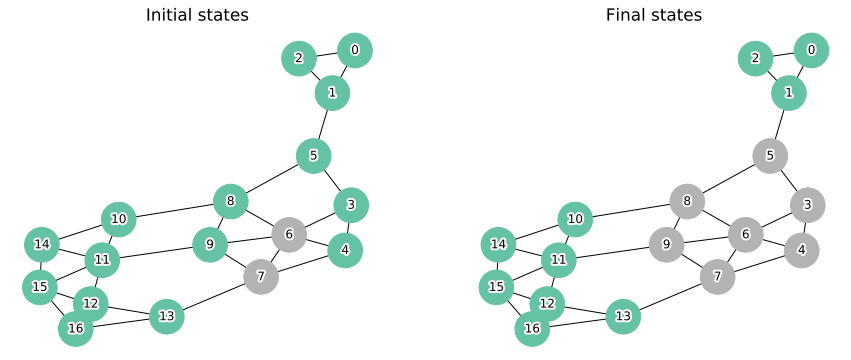

In [0]:
G = make_sample_graph()
init_active, final_active = cascade_propagation(G,
                                                a = 3,
                                                b = 2,
                                                init_active = [7,6],
                                                max_iter = 100000)

show_propagation(G,init_active,final_active)

**Another example**

Iteration 0
Infect nodes: [21 22 28 30 35 36 37 39]
Iteration 1
Infect nodes: [23 25 27 29 38]
Iteration 2
Infect nodes: [ 3 13]
Iteration 3
Finished propagation


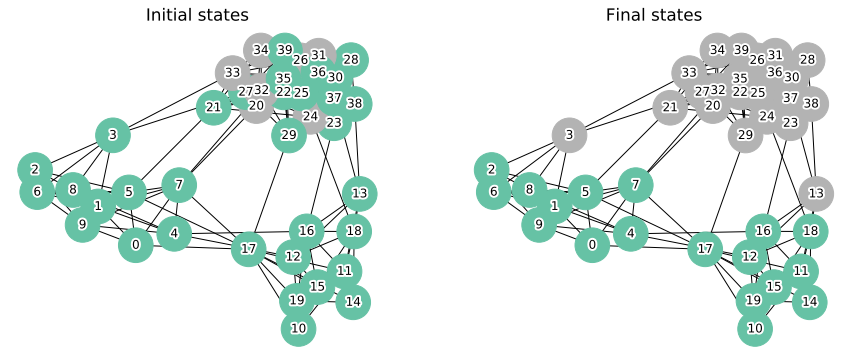

In [0]:
from functools import reduce
arrG = [nx.erdos_renyi_graph(10, 0.6)]* 2
arrG.append(nx.erdos_renyi_graph(20, 0.6))
G = reduce(lambda g1,g2: nx.disjoint_union(g1,g2), arrG)
edList = zip(np.random.randint(0,10,size=(5,)), np.random.randint(10,20,size=(5,)))
G.add_edges_from(edList)
edList = zip(np.random.randint(0,10,size=(5,)), np.random.randint(20,40,size=(5,)))
G.add_edges_from(edList)
edList = zip(np.random.randint(10,20,size=(5,)), np.random.randint(20,40,size=(5,)))
G.add_edges_from(edList)
pos = nx.spring_layout(G)
nx.draw(G, pos=pos)
init_active, final_active = cascade_propagation(G,
                                                a = 5,
                                                b = 2,
                                                init_active = [20,24,33,34,31,32,26],
                                                max_iter = 100000)

show_propagation(G,init_active,final_active)

**Cluster $\{0,1,2\}$**
- For node 1: 2/3 of neighbors inside cluster    
- For node 2: 100% of neighbors inside cluster    
- For node 0: 100% of neighbors inside cluster   
Cluster density = 2/3  

**Cluster $\{10……16\}$**       
*Cluster density = 2/3*      

For cascade to get into cluster $q <= 1- \rho$


与社群内连接最少的节点和外部节点连接的比例大于阈值    

这说明：一个紧密连接的社群具有较高的抵御传播的能力，即使社群中某些节点与外界产生了一些连接，也不影响社群内部


**You can put weight on edges, for exmaple, opionion leader has larger influence**     


**Problem: Every one has a fixed threshold, however, some people require much less / more than that**

### Threshold models form collective behavior  (Everyone talks to everyone)
- Adoption of innovation, voting, applausee, leaving social occasion, riots
- Group of people, **each to make a decision**
- **Binary** mutually exclusive decision: adopt/reject, stay/go, join/not join
- Every person has own preferenceee, decision threshold
- Dynamical proceess with equillibrium outcome(final proportion of making each decision)
- Example: insitigator + crowd         
5,5,5,5,5,5,5,5,5,5  avg = 5       
1,2,3,4,5,6,7,8,9  avg = 5 (domino effect)     
2,3,4,5,6,7,8,9  avg = 5  


Performance end:     
one person applaud, others follows        
one person stand up and leave, other people leave

Protesters been arrested, other one .....      
protesters didn't get arrested, game changer, other one follows


**Most of people has a threshold**      
**The thresholds may be different for differentt person**       
**Average threshold can not represent probability of propagation**      

### Granovetter model
Person $i$ 有一个threshold $\theta(i)$        
假设有$x$个人参与了活动        
若 $x>\theta(i)$ -> $i$参加活动，否则$i$不参加活动         
整个过程，$i$就站在一边儿看，看到好多人都去了，他也去。    

$f(x)$ 当threshold $\theta = x$时，参加活动的人数     
$F(x)$ - 累计分布方程, $\theta <=x$时参加的总人数 $F(x) = \sum_{x'}^{x}f(x')$   
<br>     
*Process:*          
Initiate $x_0$  already joined       
First time step:       
    There are $F(x_0)$ people with threshold $\theta < x$ ready to join       
    $x_1 = F(x_0)$      
    $x_2 = F(x_1)$   
    $x_{t+1} = F(x_t)$     

Fixed point of dynamical model
    $x^* = F(x^*)$    


**If you want to make a prediction, you should know the distribution**


In [0]:
def cdf(arr):
    return np.arange(1,len(arr) + 1)/100,np.sort(arr)

**Less than stable point - increasee**       
**Larger than stable point - shrink**

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


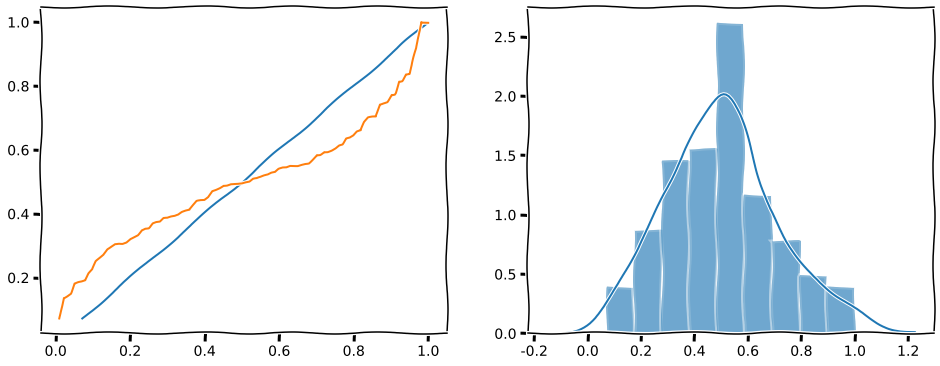

In [0]:
figsize(16,6)
plt.subplot(1,2,1)
dist = np.clip(np.random.normal(0.5,0.2,size = 100),0,1)
x,y = cdf(dist)
plt.plot([dist.min(),dist.max()],[dist.min(),dist.max()])
plt.plot(x,y)

plt.subplot(1,2,2)
sns.distplot(dist)      
plt.show()

**If less than stable point, shrink to zero**

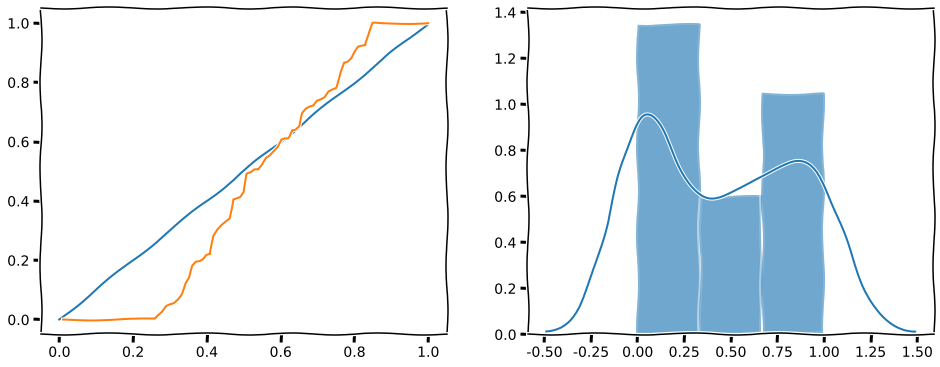

In [0]:
figsize(16,6)
plt.subplot(1,2,1)
dist = np.clip(np.random.normal(0.35,0.7,size = 100),0,1)
x,y = cdf(dist)
plt.plot([dist.min(),dist.max()],[dist.min(),dist.max()])
plt.plot(x,y)

plt.subplot(1,2,2)
sns.distplot(dist)      
plt.show()

**If there are any initiators, propagation proceeds**

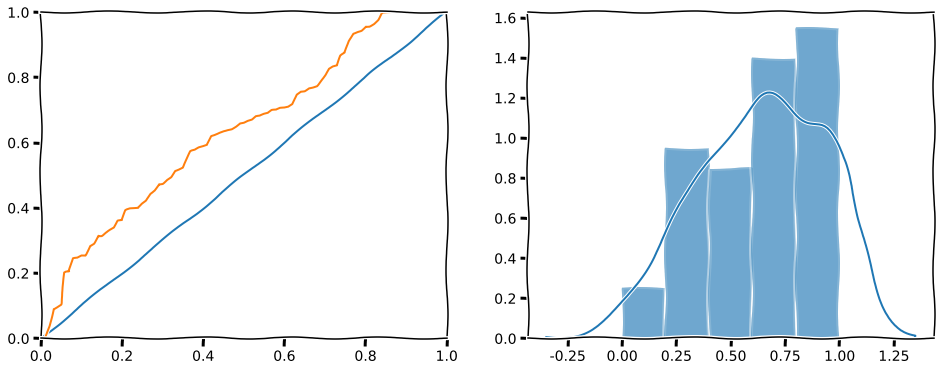

In [0]:
figsize(16,6)
plt.subplot(1,2,1)
dist = np.clip(np.random.normal(0.5,0.32,size = 100) + 0.15,0,1)
x,y = cdf(dist)
plt.plot([dist.min(),dist.max()],[dist.min(),dist.max()])
plt.plot(x,y)
plt.xlim(0,1)
plt.ylim(0,1)

plt.subplot(1,2,2)
sns.distplot(dist)      
plt.show()

### Linear Threshold Summary    
- Influence only comes from NN $N(i)$ nodes, $w_{ij}$ influence $i \to j$
- Require$\sum_{j \in N(i)}w_{ji} <=1$
- Each node has a random acceptance threshold from $\theta_{i} \in [0,1]$
- Activation: fraction of active nodes exceeds threshold      
$\sum\limits_{activate j \in N(i)} w_{ji} > \theta_{i}$
- Initial set of active nodes $A_{0}$, iterative process with discrete time steps
- Progressive process, only nonactive $\to$ active


In [0]:
def linear_threshold(G,
                     init_active = [6,7],
                     max_iter = 10,
                     w = None,
                     theta = None, 
                     theta_method = 'normal', 
                     theta_mean =.6, 
                     theta_std = 0.2,
                     theta_default = .4,
                     verbose = True
                     ):
    
    '''
        Infection model, each node has its own binary threshold, and its own infection vector

        Parameters:
        --------
            G: networkx graph (node label startswith 0 increment by 1 for next node)
            init_active: initial active node labels - list of integers
            max_iter: maximum iterations - integer
            w: preference vector, 2d numpy array, wij represents capacity of node j to infect node i
            theta: personalized threshold: 1d numpy array
            theta_method: initialize theta as a normal distribution or identity distribution, 'normal' or 'equal'
            theta_mean: if using normal distributed vector, specify mean - float
            theta_std: if using normal distributed vector, specify standard deviation - float
            theta_default: if using 'equal', specify value - float
            vecbose: boolean, print result of not

        Returns:
        --------
            initial active vector
            final active vector
    '''

    # some graph parameters
    A = np.array(nx.adj_matrix(G).todense())
    deg = list(dict(G.degree()).values())
    deg = np.array([d if d>0 else 1e-7 for d in deg])
    n = A.shape[0]

    # threshold vector
    if theta is None:
        if theta_method == 'normal':
            theta = np.clip(np.random.normal(theta_mean,theta_std,size = n),0.05,0.95)
        if theta_method == 'equal':
            theta = theta_default

    # influence matrix
    w = (np.ones(A.shape) * A / deg.reshape((n,1))).T

    cur_active = np.zeros(shape = n,dtype = int)
    cur_active[init_active] = 1
    init_active = cur_active.copy()

    for i in range(max_iter):

        if verbose:
            print('Iteration {}'.format(i))
        inactive_ids = np.where(cur_active == 0)[0]
        cur_theta = theta[cur_active == 0]
        idx = (A[np.ix_(cur_active == 1, cur_active ==0)] * w[np.ix_(cur_active == 1, cur_active ==0)]).sum(axis = 0) > cur_theta
        if np.any(idx):
            cur_active[inactive_ids[idx]] = 1
        else:
            if i==0:
                if verbose:
                    print("Failed to propagation 1 step")
            break
        if verbose:
            print('Update nodes {}'.format(inactive_ids[idx]))

    return init_active, cur_active

Iteration 0
Update nodes [ 4  9 13]
Iteration 1
Update nodes [3 8]
Iteration 2
Update nodes [ 5 10]
Iteration 3
Update nodes [14]
Iteration 4


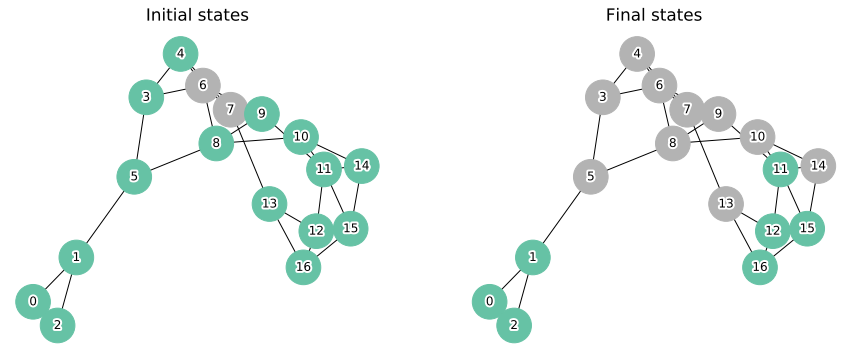

In [0]:
G = make_sample_graph()
init_active,final_active = linear_threshold(G,
                                          init_active = [6,7],
                                          max_iter = 10,
                                          w = None,
                                          theta = None,
                                          theta_method = 'normal',
                                          theta_mean =.4,
                                          theta_std = 0.2,
                                          theta_default = .4)

show_propagation(G,init_active,final_active)

Iteration 0
Update nodes [0 2 9]
Iteration 1
Update nodes [1 3 5 8]
Iteration 2
Update nodes [ 4 20]
Iteration 3
Update nodes [29 31 36]
Iteration 4
Update nodes [25 26 27]
Iteration 5
Update nodes [28 30]
Iteration 6
Update nodes [21 23 38]
Iteration 7
Update nodes [22 32 33 35 37]
Iteration 8
Update nodes [24 34 39]
Iteration 9
Update nodes [15 17]


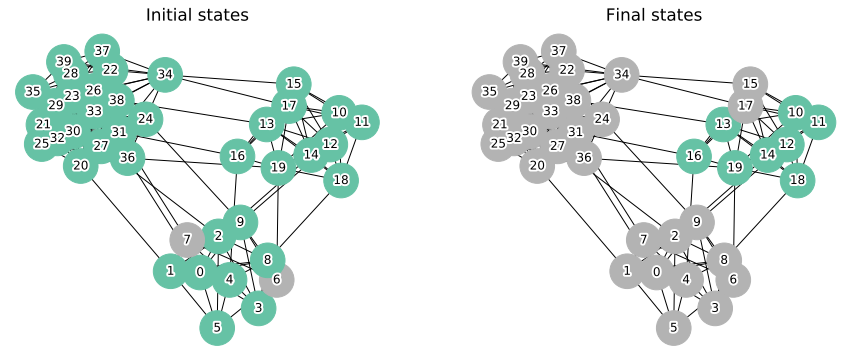

In [0]:
from functools import reduce
arrG = [nx.erdos_renyi_graph(10, 0.6)]* 2
arrG.append(nx.erdos_renyi_graph(20, 0.6))
G = reduce(lambda g1,g2: nx.disjoint_union(g1,g2), arrG)
edList = zip(np.random.randint(0,10,size=(5,)), np.random.randint(10,20,size=(5,)))
G.add_edges_from(edList)
edList = zip(np.random.randint(0,10,size=(5,)), np.random.randint(20,40,size=(5,)))
G.add_edges_from(edList)
edList = zip(np.random.randint(10,20,size=(5,)), np.random.randint(20,40,size=(5,)))
G.add_edges_from(edList)
pos = nx.spring_layout(G)
init_active,final_active = linear_threshold(G,
                                          init_active = [6,7],
                                          max_iter = 10,
                                          w = None,
                                          theta = None,
                                          theta_method = 'normal',
                                          theta_mean =.3,
                                          theta_std = 0.2,
                                          theta_default = .4)

show_propagation(G,init_active,final_active)

# Interesting, a personalized linear threshold simulation!

### Cascade in random network
- When average node degree gets larger, it becomes difficult to propagate
- When threshold getting larger, difficult to propagate

**Enough connections to spread information, however, difficult to convince someone**      

**Different from rumor spreading**

**<font color='red'>For cascade model, the node with highest degree may be not the one with highest propagation capacity(as source node) -  needs a lot of active nodes around</font>**

**<font color = 'darkred'>How do we select nodes with highest influence.</font>**

# Influence Maximization

### Submodular Functions (次模函数: 函数f代表传播)    
*Theory:*      
Set function f is submodular, if for sets $S,T$ and $S \subseteq T$, any $v \not\in T$:      
$f(S \cup \{v\}) - f(S) >= f(T \cup \{v\}) - f(T)$
- Function of diminishing returns
- Function $f$ is monotone $f(S \cup \{v\}) >= f(S)$

Intuition:
S比T小，S扩张一个或一些节点，最终传播区域的增量 $>=$ T 扩张相同的节点， 产生的传播区域的增量。

**我们不断的增加初始节点的数量，对最终的传播区域影响是越来越小的。**          

*Greedy optimization:*           
We have a network, our goal is to find nodes that are most influential.    
- Go through all nodes.
- Calculate the influence due each node.
- Select node with most influence.
- Got the first seed node.
- Keep the first most influential node $u$
- Randomly pick other node $v1$
- Calculate influence due to ${u,v1}$
- Go through all nodes $vi, vi \not= u$

In [0]:
G = make_sample_graph()
theta = np.clip(np.random.normal(.4,.2, size = len(G.nodes())),0.05,0.95)

In [0]:
def greedy_optimize(G, theta):

    '''
        Greedy optimization algorithm, pick node, calculate infection size, 
        Select node with maximum infection size. add to initiator pool
        repeat to select next node...repeat...repat  
        until all nodes are selected

        Infection size is calculated using linear threshold model

        Parameters:
        --------
            G: networkx graph
            theta: personalized threshold vector

        Returns:
        --------:
            a list of nodes select in sequence (if all nodes are infected, stop)
            infection_size: list of integer representing infection size under current initiators
    
    '''
    
    picked_nodes = []
    infection_sizes = []
    candidates = list(set(G.nodes()).difference(set(picked_nodes)))

    iters =0
    while len(candidates) > 0:
        iters += 1
        print("Picking {}th node.".format(iters))

        infection = dict()
        for node in candidates:
            init_active,final_active = linear_threshold(G,
                                                    init_active = picked_nodes + [node],
                                                    max_iter = 100,
                                                    w = None,
                                                    theta = theta,
                                                    theta_method = 'normal',
                                                    theta_mean =.4,
                                                    theta_std = 0.2,
                                                    theta_default = .4,
                                                    verbose = False)
            infection[node] = final_active.sum()

        picked_node = sorted(infection, key = infection.get,reverse = True)[0]
        picked_nodes += [picked_node]
        infection_size = infection[picked_node]
        infection_sizes.append(infection_size)

        if infection_size == len(G.nodes()):
            print('Propagation all graph, stop.')
            break

        candidates = list(set(G.nodes()).difference(set(picked_nodes)))
    return picked_nodes, infection_sizes

Picking 1th node.
Picking 2th node.
Propagation all graph, stop.


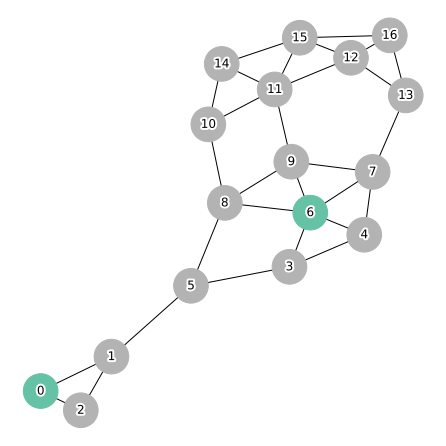

In [0]:
picked_nodes, infection_sizes = greedy_optimize(G, theta)
colors = [1 if n in picked_nodes else 2 for n in list(G.nodes())]
figsize(6,6)
pos = nx.spring_layout(G)
nx.draw(G,with_labels = True,node_size = 1200,node_color = colors,cmap = plt.get_cmap('Set2'),pos = pos)

*It is difficult to propagate into community ${0,1,2}$ by node ${6}$, with the help of node ${0}$, propagation can be preceed into community ${0,1,2}$*

Picking 1th node.
Picking 2th node.
Picking 3th node.
Propagation all graph, stop.


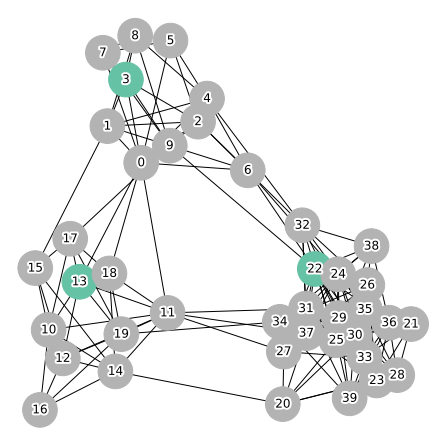

In [0]:
from functools import reduce
arrG = [nx.erdos_renyi_graph(10, 0.6)]* 2
arrG.append(nx.erdos_renyi_graph(20, 0.6))
G = reduce(lambda g1,g2: nx.disjoint_union(g1,g2), arrG)
edList = zip(np.random.randint(0,10,size=(5,)), np.random.randint(10,20,size=(5,)))
G.add_edges_from(edList)
edList = zip(np.random.randint(0,10,size=(5,)), np.random.randint(20,40,size=(5,)))
G.add_edges_from(edList)
edList = zip(np.random.randint(10,20,size=(5,)), np.random.randint(20,40,size=(5,)))
G.add_edges_from(edList)
pos = nx.spring_layout(G)
theta = np.clip(np.random.normal(.4,.2, size = len(G.nodes())),0.05,0.95)

picked_nodes, infection_sizes = greedy_optimize(G, theta)
colors = [1 if n in picked_nodes else 2 for n in list(G.nodes())]
figsize(6,6)
pos = nx.spring_layout(G)
nx.draw(G,with_labels = True,node_size = 1200,node_color = colors,cmap = plt.get_cmap('Set2'),pos = pos)

### Propagation with uniform preference

Picking 1th node.
Picking 2th node.
Picking 3th node.
Picking 4th node.
Picking 5th node.
Picking 6th node.
Picking 7th node.
Propagation all graph, stop.


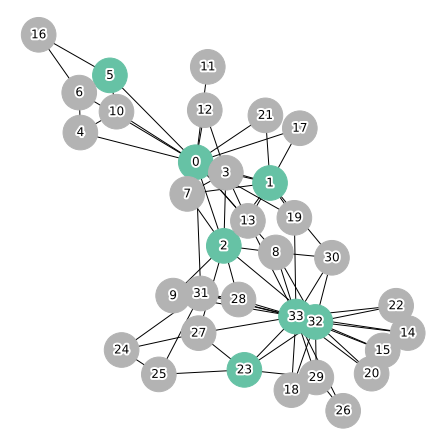

In [0]:
G = nx.karate_club_graph()
theta = np.clip(np.random.normal(.5,.0, size = len(G.nodes())),0.05,0.95)
picked_nodes, infection_sizes = greedy_optimize(G, theta)
colors = [1 if n in picked_nodes else 2 for n in list(G.nodes())]
figsize(6,6)
pos = nx.spring_layout(G)
nx.draw(G,with_labels = True,node_size = 1200,node_color = colors,cmap = plt.get_cmap('Set2'),pos = pos)

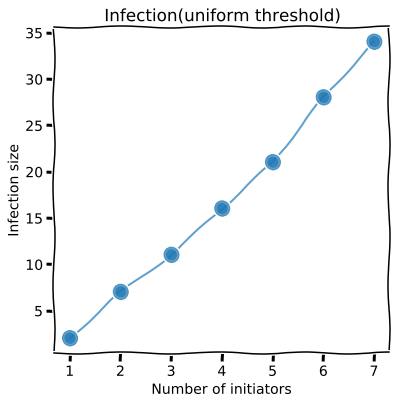

In [0]:
plt.plot(np.arange(1,len(picked_nodes) + 1),infection_sizes,marker = '.',markersize = 30,alpha = .7)
plt.title("Infection(uniform threshold)")
plt.xlabel("Number of initiators")
plt.ylabel('Infection size')
plt.show()

### Propagation with random preference

Picking 1th node.
Picking 2th node.
Propagation all graph, stop.
Picking 1th node.
Picking 2th node.
Propagation all graph, stop.
Picking 1th node.
Propagation all graph, stop.
Picking 1th node.
Picking 2th node.
Propagation all graph, stop.
Picking 1th node.
Picking 2th node.
Propagation all graph, stop.
Picking 1th node.
Picking 2th node.
Propagation all graph, stop.
Picking 1th node.
Picking 2th node.
Picking 3th node.
Propagation all graph, stop.
Picking 1th node.
Picking 2th node.
Propagation all graph, stop.
Picking 1th node.
Propagation all graph, stop.
Picking 1th node.
Propagation all graph, stop.
Picking 1th node.
Picking 2th node.
Picking 3th node.
Propagation all graph, stop.
Picking 1th node.
Picking 2th node.
Picking 3th node.
Propagation all graph, stop.


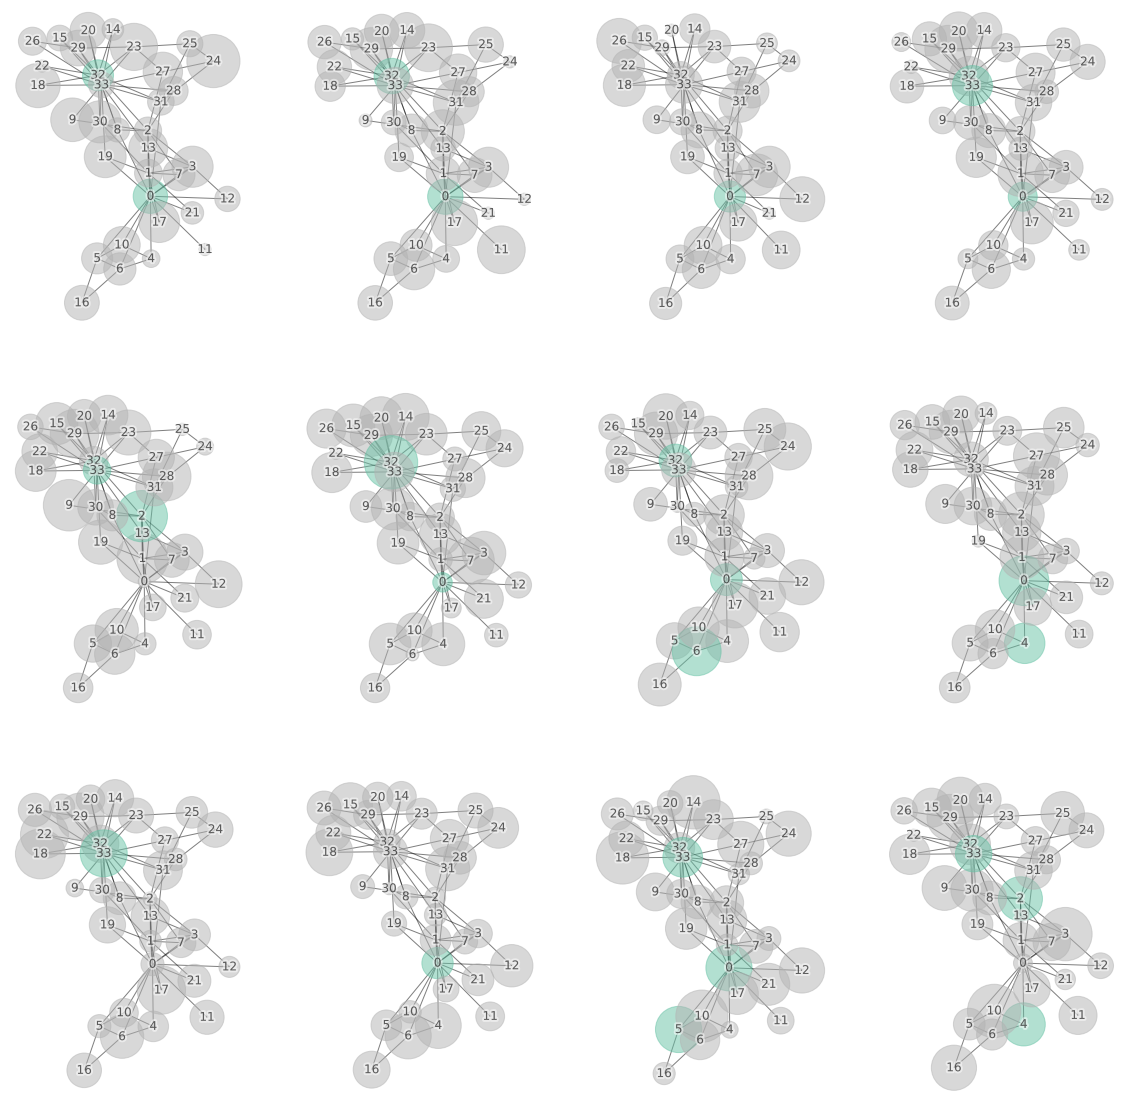

In [0]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G)
figsize(20,20)
for i in range(12):
    theta = np.clip(np.random.normal(.4,.2, size = len(G.nodes())),0.05,0.95)
    picked_nodes, infection_sizes = greedy_optimize(G, theta)
    colors = [1 if n in picked_nodes else 2 for n in list(G.nodes())]
    plt.subplot(3,4,i+1)
    nx.draw(G,with_labels = True,node_size = theta*3000,node_color = colors,cmap = plt.get_cmap('Set2'),pos = pos,alpha = 0.5)
plt.show()